In [7]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import cluster, datasets, mixture

In [3]:
noisy_moons = datasets.make_moons(n_samples=10000, noise=.05)[0].astype(np.float32)

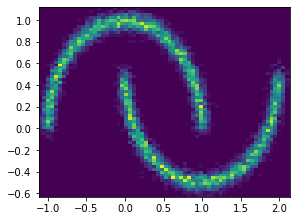

In [4]:
figure(figsize=(4.5,3.5))
hist2d(noisy_moons[:,0], noisy_moons[:,1],64);

In [5]:
import tensorflow as tf

from tensorflow_probability.python.bijectors import bijector

__all__ = [
    "RealNVP",
    "real_nvp_default_template"
]


class RealNVP(bijector.Bijector):
  """RealNVP "affine coupling layer" for vector-valued events.
  Real NVP models a normalizing flow on a `D`-dimensional distribution via a
  single `D-d`-dimensional conditional distribution [(Dinh et al., 2017)][1]:
  `y[d:D] = x[d:D] * tf.exp(log_scale_fn(x[0:d])) + shift_fn(x[0:d])`
  `y[0:d] = x[0:d]`
  The last `D-d` units are scaled and shifted based on the first `d` units only,
  while the first `d` units are 'masked' and left unchanged. Real NVP's
  `shift_and_log_scale_fn` computes vector-valued quantities. For
  scale-and-shift transforms that do not depend on any masked units, i.e.
  `d=0`, use the `tfb.Affine` bijector with learned parameters instead.
  Masking is currently only supported for base distributions with
  `event_ndims=1`. For more sophisticated masking schemes like checkerboard or
  channel-wise masking [(Papamakarios et al., 2016)[4], use the `tfb.Permute`
  bijector to re-order desired masked units into the first `d` units. For base
  distributions with `event_ndims > 1`, use the `tfb.Reshape` bijector to
  flatten the event shape.
  Recall that the MAF bijector [(Papamakarios et al., 2016)][4] implements a
  normalizing flow via an autoregressive transformation. MAF and IAF have
  opposite computational tradeoffs - MAF can train all units in parallel but
  must sample units sequentially, while IAF must train units sequentially but
  can sample in parallel. In contrast, Real NVP can compute both forward and
  inverse computations in parallel. However, the lack of an autoregressive
  transformations makes it less expressive on a per-bijector basis.
  A "valid" `shift_and_log_scale_fn` must compute each `shift` (aka `loc` or
  "mu" in [Papamakarios et al. (2016)][4]) and `log(scale)` (aka "alpha" in
  [Papamakarios et al. (2016)][4]) such that each are broadcastable with the
  arguments to `forward` and `inverse`, i.e., such that the calculations in
  `forward`, `inverse` [below] are possible. For convenience,
  `real_nvp_default_nvp` is offered as a possible `shift_and_log_scale_fn`
  function.
  NICE [(Dinh et al., 2014)][2] is a special case of the Real NVP bijector
  which discards the scale transformation, resulting in a constant-time
  inverse-log-determinant-Jacobian. To use a NICE bijector instead of Real
  NVP, `shift_and_log_scale_fn` should return `(shift, None)`, and
  `is_constant_jacobian` should be set to `True` in the `RealNVP` constructor.
  Calling `real_nvp_default_template` with `shift_only=True` returns one such
  NICE-compatible `shift_and_log_scale_fn`.
  Caching: the scalar input depth `D` of the base distribution is not known at
  construction time. The first call to any of `forward(x)`, `inverse(x)`,
  `inverse_log_det_jacobian(x)`, or `forward_log_det_jacobian(x)` memoizes
  `D`, which is re-used in subsequent calls. This shape must be known prior to
  graph execution (which is the case if using tf.layers).
  #### Example Use
  ```python
  tfd = tfp.distributions
  tfb = tfp.bijectors
  # A common choice for a normalizing flow is to use a Gaussian for the base
  # distribution. (However, any continuous distribution would work.) E.g.,
  nvp = tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
      bijector=tfb.RealNVP(
          num_masked=2,
          shift_and_log_scale_fn=tfb.real_nvp_default_template(
              hidden_layers=[512, 512])))
  x = nvp.sample()
  nvp.log_prob(x)
  nvp.log_prob(0.)
  ```
  For more examples, see [Jang (2018)][3].
  #### References
  [1]: Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio. Density Estimation
       using Real NVP. In _International Conference on Learning
       Representations_, 2017. https://arxiv.org/abs/1605.08803
  [2]: Laurent Dinh, David Krueger, and Yoshua Bengio. NICE: Non-linear
       Independent Components Estimation. _arXiv preprint arXiv:1410.8516_,
       2014. https://arxiv.org/abs/1410.8516
  [3]: Eric Jang. Normalizing Flows Tutorial, Part 2: Modern Normalizing Flows.
       _Technical Report_, 2018. http://blog.evjang.com/2018/01/nf2.html
  [4]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  """

  def __init__(self,
               num_masked,
               shift_and_log_scale_fn,
               is_constant_jacobian=False,
               validate_args=False,
               name=None):
    """Creates the Real NVP or NICE bijector.
    Args:
      num_masked: Python `int` indicating that the first `d` units of the event
        should be masked. Must be in the closed interval `[1, D-1]`, where `D`
        is the event size of the base distribution.
      shift_and_log_scale_fn: Python `callable` which computes `shift` and
        `log_scale` from both the forward domain (`x`) and the inverse domain
        (`y`). Calculation must respect the "autoregressive property" (see class
        docstring). Suggested default
        `masked_autoregressive_default_template(hidden_layers=...)`.
        Typically the function contains `tf.Variables` and is wrapped using
        `tf.make_template`. Returning `None` for either (both) `shift`,
        `log_scale` is equivalent to (but more efficient than) returning zero.
      is_constant_jacobian: Python `bool`. Default: `False`. When `True` the
        implementation assumes `log_scale` does not depend on the forward domain
        (`x`) or inverse domain (`y`) values. (No validation is made;
        `is_constant_jacobian=False` is always safe but possibly computationally
        inefficient.)
      validate_args: Python `bool` indicating whether arguments should be
        checked for correctness.
      name: Python `str`, name given to ops managed by this object.
    Raises:
      ValueError: If num_masked < 1.
    """
    name = name or "real_nvp"
    if num_masked <= 0:
      raise ValueError("num_masked must be a positive integer.")
    self._num_masked = num_masked
    # At construction time, we don't know input_depth.
    self._input_depth = None
    self._shift_and_log_scale_fn = shift_and_log_scale_fn
    super(RealNVP, self).__init__(
        forward_min_event_ndims=1,
        is_constant_jacobian=is_constant_jacobian,
        validate_args=validate_args,
        name=name)

  def _cache_input_depth(self, x):
    if self._input_depth is None:
      self._input_depth = 2
      if self._input_depth is None:
        raise NotImplementedError(
            "Rightmost dimension must be known prior to graph execution.")
      if self._num_masked >= self._input_depth:
        raise ValueError(
            "Number of masked units must be smaller than the event size.")

  def _forward(self, x, **condition_kwargs):
    self._cache_input_depth(x)
    # Performs scale and shift.
    x0, x1 = tf.split(x, num_or_size_splits=2, axis=-1)
    shift, log_scale = self._shift_and_log_scale_fn(
        x0, self._input_depth - self._num_masked, **condition_kwargs)
    y1 = x1
    if log_scale is not None:
      y1 *= tf.exp(log_scale)
    if shift is not None:
      y1 += shift
    y = tf.concat([x0, y1], axis=-1)
    return y

  def _inverse(self, y, **condition_kwargs):
    self._cache_input_depth(y)
    # Performs un-shift and un-scale.
    y0, y1 =tf.split(y, num_or_size_splits=2, axis=-1) 
    shift, log_scale = self._shift_and_log_scale_fn(
        y0, self._input_depth - self._num_masked, **condition_kwargs)
    x1 = y1
    if shift is not None:
      x1 -= shift
    if log_scale is not None:
      x1 *= tf.exp(-log_scale)
    x = tf.concat([y0, x1], axis=-1)
    return x

  def _inverse_log_det_jacobian(self, y, **condition_kwargs):
    self._cache_input_depth(y)
    y0, y1 =tf.split(y, num_or_size_splits=2, axis=-1) 
    _, log_scale = self._shift_and_log_scale_fn(
        y0, self._input_depth - self._num_masked, **condition_kwargs)
    if log_scale is None:
      return tf.constant(0., dtype=y.dtype, name="ildj")
    return -tf.reduce_sum(input_tensor=log_scale, axis=-1)

  def _forward_log_det_jacobian(self, x, **condition_kwargs):
    self._cache_input_depth(x)
    x0, x1 = tf.split(x, num_or_size_splits=2, axis=-1)
    _, log_scale = self._shift_and_log_scale_fn(
        x0, self._input_depth - self._num_masked, **condition_kwargs)
    if log_scale is None:
      return tf.constant(0., dtype=x.dtype, name="fldj")
    return tf.reduce_sum(input_tensor=log_scale, axis=-1)


def real_nvp_default_template(hidden_layers,
                              shift_only=False,
                              activation=tf.nn.relu,
                              name=None,
                              *args,  # pylint: disable=keyword-arg-before-vararg
                              **kwargs):
  """Build a scale-and-shift function using a multi-layer neural network.
  This will be wrapped in a make_template to ensure the variables are only
  created once. It takes the `d`-dimensional input x[0:d] and returns the `D-d`
  dimensional outputs `loc` ("mu") and `log_scale` ("alpha").
  The default template does not support conditioning and will raise an
  exception if `condition_kwargs` are passed to it. To use conditioning in
  real nvp bijector, implement a conditioned shift/scale template that
  handles the `condition_kwargs`.
  Arguments:
    hidden_layers: Python `list`-like of non-negative integer, scalars
      indicating the number of units in each hidden layer. Default: `[512, 512].
    shift_only: Python `bool` indicating if only the `shift` term shall be
      computed (i.e. NICE bijector). Default: `False`.
    activation: Activation function (callable). Explicitly setting to `None`
      implies a linear activation.
    name: A name for ops managed by this function. Default:
      "real_nvp_default_template".
    *args: `tf.layers.dense` arguments.
    **kwargs: `tf.layers.dense` keyword arguments.
  Returns:
    shift: `Float`-like `Tensor` of shift terms ("mu" in
      [Papamakarios et al.  (2016)][1]).
    log_scale: `Float`-like `Tensor` of log(scale) terms ("alpha" in
      [Papamakarios et al. (2016)][1]).
  Raises:
    NotImplementedError: if rightmost dimension of `inputs` is unknown prior to
      graph execution, or if `condition_kwargs` is not empty.
  #### References
  [1]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  """

  with tf.name_scope(name or "real_nvp_default_template"):

    def _fn(x, output_units, **condition_kwargs):
      """Fully connected MLP parameterized via `real_nvp_template`."""
      if condition_kwargs:
        raise NotImplementedError(
            "Conditioning not implemented in the default template.")

      reshape_output = lambda x: x
      for units in hidden_layers:
        x = tf.compat.v1.layers.dense(
            inputs=x,
            units=units,
            activation=activation,
            *args,  # pylint: disable=keyword-arg-before-vararg
            **kwargs)
      x = tf.compat.v1.layers.dense(
          inputs=x,
          units=(1 if shift_only else 2) * output_units,
          activation=None,
          *args,  # pylint: disable=keyword-arg-before-vararg
          **kwargs)
      if shift_only:
        return reshape_output(x), None
      shift, log_scale = tf.split(x, 2, axis=-1)
      return reshape_output(shift), reshape_output(log_scale)

    return tf.compat.v1.make_template("real_nvp_default_template", _fn)

In [74]:
tf.reset_default_graph()

batch_size = 1024

x = tf.placeholder(tf.float32, shape=(batch_size,2))
lr = tf.placeholder_with_default(0.001, shape=())

def flow_module_spec():
    x = tf.placeholder(tf.float32, shape=[None, 2])
    chain = [ RealNVP(1,
                                shift_and_log_scale_fn=real_nvp_default_template(hidden_layers=[128,128],
                                                                                     activation=tf.nn.leaky_relu)),
              tfb.Permute([1,0]),
              RealNVP(1,
                                shift_and_log_scale_fn=real_nvp_default_template(hidden_layers=[128,128],
                                                                                     activation=tf.nn.leaky_relu)),

              tfb.Permute([1,0]),
              RealNVP(1,
                                shift_and_log_scale_fn=real_nvp_default_template(hidden_layers=[128,128],
                                                                                        activation=tf.nn.leaky_relu)),
              tfb.Permute([1,0]),
              RealNVP(1,
                                shift_and_log_scale_fn=real_nvp_default_template(hidden_layers=[128,128],
                                                                                        activation=tf.nn.leaky_relu)),
            ]
    bij = tfb.Chain(chain)

    prior  = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_identity_multiplier=1.0)
    distribution = tfd.TransformedDistribution(prior, bijector=bij)
    
    log_prob = distribution.log_prob(x)
    hub.add_signature(inputs=x,
                      outputs=log_prob)

flow_spec = hub.create_module_spec(flow_module_spec)
flow = hub.Module(flow_spec, name='flow_module', trainable=True)

In [75]:
loss = - tf.reduce_mean(flow(x))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [76]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss)

In [77]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [78]:
losses = []

In [79]:
for i in range(5000):
    ims = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    _, l = sess.run([opt_op, loss], feed_dict={x:ims, lr:0.001})
    losses.append(l)
    if i %100 ==0:
        print(i, l)

0 2.4453485
100 1.6535901
200 1.2953004
300 1.1509811
400 1.0954278
500 0.96329486
600 1.0440545
700 0.83950615
800 0.940884
900 0.64225376
1000 0.5296452
1100 0.51086026
1200 0.47699916
1300 0.43335018
1400 0.47138005
1500 0.4239432
1600 0.40494943
1700 0.4039541
1800 0.37303352
1900 0.3630897
2000 0.34914026
2100 0.35237804
2200 0.3262498
2300 0.3828894
2400 0.37927696
2500 0.34367394
2600 0.36978543
2700 0.36831433
2800 0.32450718
2900 0.37953505
3000 0.34915888
3100 0.37723783
3200 0.3264848
3300 0.37935752
3400 0.39862025
3500 0.33713886
3600 0.3687825
3700 0.31489778
3800 0.36391583
3900 0.3219086
4000 0.3783657
4100 0.35278112
4200 0.32514125
4300 0.39551994
4400 0.3152021
4500 0.35416675
4600 0.35850254
4700 0.34683535
4800 0.37097844
4900 0.34145513


In [80]:
xc,yc = meshgrid(linspace(-1.5,2.5,128),linspace(-1.,1.5,128))

In [81]:
tx = tf.placeholder(tf.float32, shape=(128**2,2))
vals = sess.run(flow(tx), feed_dict={tx: stack([xc.flatten(), yc.flatten()],axis=1)})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


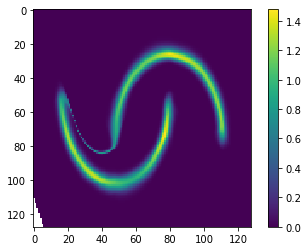

In [82]:
imshow(exp(vals.reshape((128,128)))); colorbar()

In [83]:
flow.export('../models/two_moons_realnvp_d', sess)

INFO:tensorflow:Exported TF-Hub module to: ../models/two_moons_realnvp_d


In [80]:
fake = sess.run(flow(x, as_dict=True)['samples'], feed_dict={x:ims, lr:0.001})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [81]:
fake.shape

(1024, 2)

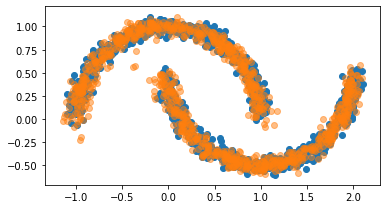

In [82]:
scatter(noisy_moons[:1024,0], noisy_moons[:1024,1])
scatter(fake[:,0], fake[:,1],alpha=0.5)
gca().set_aspect('equal')

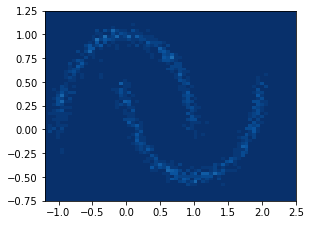

In [83]:
figure(figsize=(4.5,3.5))
hist2d(fake[:,0], fake[:,1],64,vmax=30,range=[[-1.2,2.5],[-0.75,1.25]],cmap='Blues_r',vmin=0);

In [12]:
flow.export('../models/two_moons_realnvp_b', sess)

INFO:tensorflow:Exported TF-Hub module to: ../models/two_moons_realnvp_b


In [ ]:
import tensorflow_hub as hub
flow = hub.Module('../models/two_moons_realnvp_c/')
x = tf.placeholder(shape=[1024, 2], dtype=tf.float32)
g = tf.gradients(flow(x),x)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
yo,po = sess.run([tf.norm(g,axis=-1),x], feed_dict={x: randn(1024,2)})
scatter(po[:,0], po[:,1], c=clip(-yo[0],-100,100));colorbar()
xlim(-1,2)
ylim(-1,2)